# Bug classifier

The purpose of this project was to gain some experience using fast.ai, this is my first attempt at creating an image classifier. For more information see fast.ai lessons: 1,2 and 3 [here](https://course.fast.ai/).

In [8]:
from fastai import *
from fastai.vision import *

In [9]:
path = Path('data/freid')
bug_path = Path(path/'bug')

if not os.path.exists(bug_path):
    os.makedirs(bug_path)

## Generate dataset

### From google images

In [10]:
classes = ['bee','wasp','moth','ant']


First, generate a list of image urls by executing a google image search and running the following code snippet:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Next, upload this datasets to the path directory and download the images:

In [13]:
download_images(path/'bee.txt', bug_path/'bee', max_pics=100)


In [14]:
download_images(path/'wasp.txt', bug_path/'wasp', max_pics=100)


In [15]:
download_images(path/'moth.txt', bug_path/'moth', max_pics=100)


In [16]:
download_images(path/'ant.txt', bug_path/'ant', max_pics=100)


Remove any images that can't be opened: 

In [17]:
for c in classes:
    print(c)
    verify_images(bug_path/c, delete=True)
    

Finally, create a databunch:

In [18]:
multi = False

np.random.seed(42)
data = ImageDataBunch.from_folder(bug_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=12).normalize(imagenet_stats)


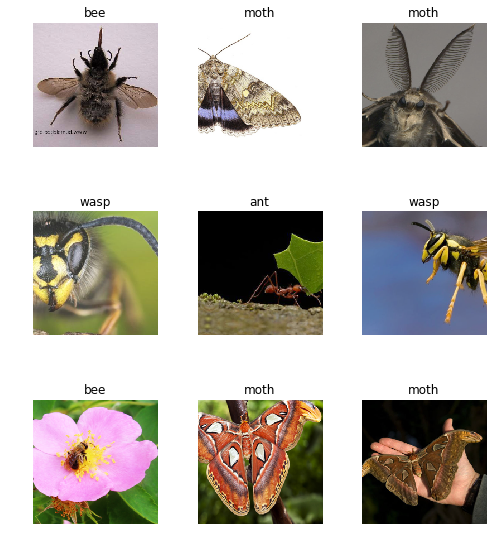

In [19]:
data.show_batch(rows=3, figsize=(7,8))


In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['ant', 'bee', 'moth', 'wasp'], 4, 308, 77)

### From csv

Upload your dataset to the path directory and add your images to a sub directory bug.

In [6]:
df = pd.read_csv(path/'example.csv')
df.head()


,image_name,tags
0,bee_1,bee flower
1,bee_2,bee
2,bee_3,bee flower
3,bee_4,bee
4,bee_5,bee


Next, create a data bunch. We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [7]:
multi = False

np.random.seed(42)
data = ImageDataBunch.from_csv(path, csv_labels='example.csv', folder='bug', suffix='.jpeg', valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=12).normalize(imagenet_stats)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
 ant lead
  if getattr(ds, 'warn', False): warn(ds.warn)


FileNotFoundError: [Errno 2] No such file or directory: 'data/freid/bug/bee_1.jpeg'

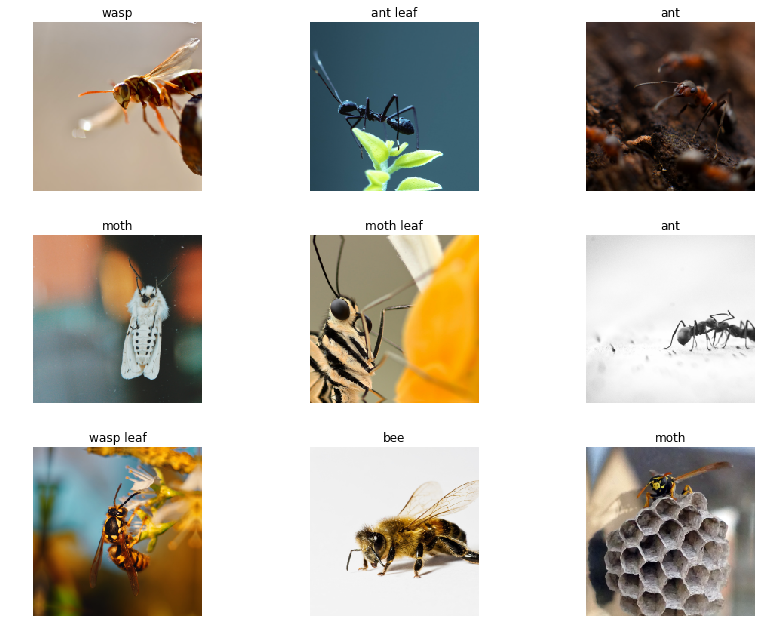

In [308]:
data.show_batch(rows=3, figsize=(12,9))

### From csv (multiclassification)

Here each picture can have multiple labels. In the csv each 'image_name' can be associated to several tags separated by spaces.

In [368]:
df = pd.read_csv(path/'example.csv')
df.head()

,image_name,tags
0,bee_1,bee flower
1,bee_2,bee
2,bee_3,bee flower
3,bee_4,bee
4,bee_5,bee


In [372]:
multi = True

np.random.seed(42)
data = (ImageList.from_csv(path, 'example.csv', folder='bug', suffix='.jpg',)
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
       .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=224)
       .databunch(bs=12,num_workers=4)
       .normalize(imagenet_stats))

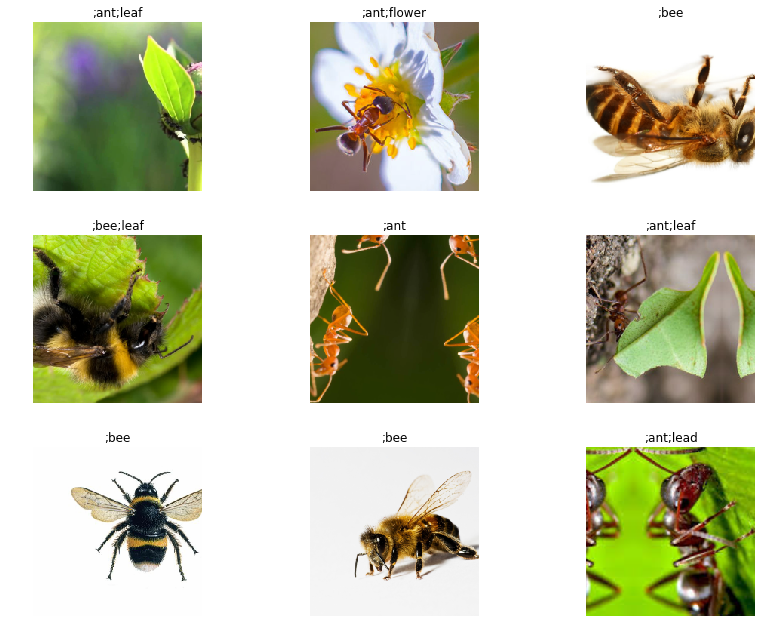

In [373]:
data.show_batch(rows=3, figsize=(12,9))

## Train model

Pick which arch you want to use: `resnet34` or `resnet50`.

In [21]:
arch = models.resnet34 #resnet50


In [22]:
if multi:
    acc_02 = partial(accuracy_thresh, thresh=0.2)
    f_score = partial(fbeta, thresh=0.2)
    learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
else:
    learn = cnn_learner(data, arch, metrics=error_rate)

In [24]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,time
0,0.276343,0.223317,0.090909,00:10
1,0.269847,0.262594,0.103896,00:11
2,0.250338,0.243131,0.116883,00:13
3,0.248924,0.259991,0.116883,00:11


In [25]:
learn.save('stage-1')


In [26]:
learn.unfreeze()


Use the LR Finder to pick a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


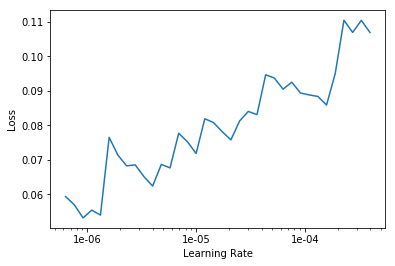

In [150]:
learn.lr_find()
learn.recorder.plot()


Set lr to the "Learning Rate" where "Loss" has the steepest descent.


In [151]:
lr=1e-6

In [152]:
learn.fit_one_cycle(3, slice(lr))


epoch,train_loss,valid_loss,error_rate,time
0,0.114792,1.092052,0.129870,00:11
1,0.106662,1.081043,0.116883,00:11
2,0.080975,1.074335,0.129870,00:13
3,0.066273,1.086341,0.129870,00:11
4,0.057779,1.069850,0.116883,00:11
5,0.066598,1.080220,0.129870,00:10


In [153]:
learn.save('stage-2')

In [154]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


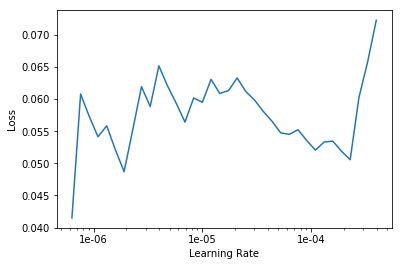

In [155]:
lr_find(learn)
learn.recorder.plot()


Set lower slice value to the "Learning Rate" where "Loss" has the steepest descent.

In [156]:
lrs=slice(1e-5,lr/5)

In [157]:
learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,error_rate,time
0,0.053073,1.071337,0.116883,00:11
1,0.064907,1.054141,0.116883,00:11
2,0.086617,1.079872,0.129870,00:12
3,0.081614,1.084076,0.129870,00:12
4,0.078408,1.056299,0.129870,00:11
5,0.068067,1.058137,0.116883,00:12


Remember, that if your training loss is more than your validation loss, then you are underfitting. You can either train for more epochs or try a different learning rate.

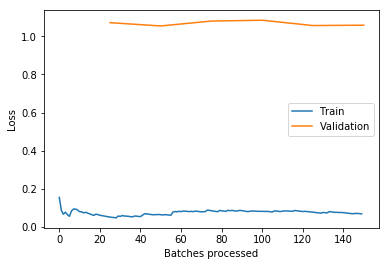

In [158]:
learn.recorder.plot_losses()

We want the learning rate to gradually increase and then decrease towards the end. 

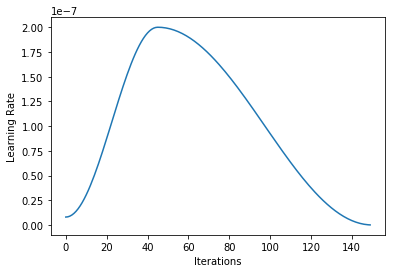

In [159]:
learn.recorder.plot_lr()


In [160]:
learn.save('stage-3')


In [161]:
learn.unfreeze()


## Interpretation

In [33]:
interp = ClassificationInterpretation.from_learner(learn)


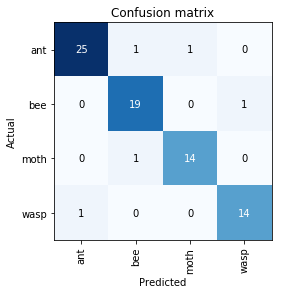

In [34]:
if multi == False:
    interp.plot_confusion_matrix()

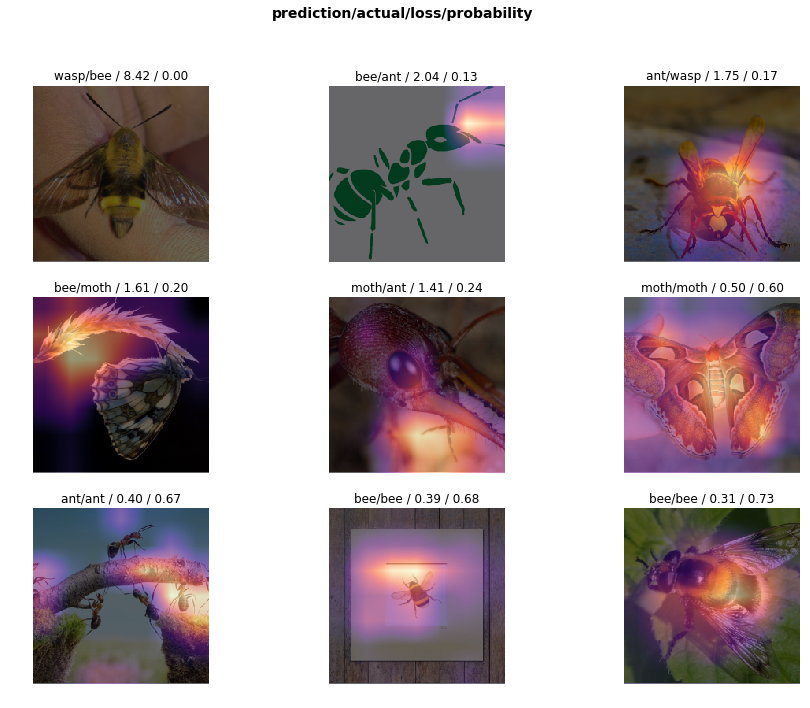

In [35]:
if multi:
    interp.plot_multi_top_losses(9, figsize=(15,11)) 
else:
    interp.plot_top_losses(9, figsize=(15,11))

In [36]:
if multi == False:
    interp.most_confused(min_val=2)

## Clean up

In [37]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [391]:
if multi == False:
    ImageCleaner(ds, idxs, path)

## Save & export model

Saves ```.pth``` file in: ```path/models/``` and exports ```.pkl``` file in: ```path/```

In [38]:
learn.save("stage-4")


In [402]:
learn.export("bug.pkl")


## Make prediction

In [169]:
img = open_image(bug_path/'bee/00000019.jpg')
#img.show(figsize=(5,5))


In [171]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class
#outputs[pred_idx].item()


Category bee